In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)


In [5]:
TRAIN_PATH = "/content/GTSRB/train_modified"
TEST_PATH  = "/content/GTSRB/test_modified"


In [6]:
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))

    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(folder, class_name)
        for file in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
                labels.append(idx)

    return images, np.array(labels), class_names


In [8]:
import zipfile

# Extract the GTSRB.zip file if the directories don't exist
if not os.path.exists(TRAIN_PATH) or not os.path.exists(TEST_PATH):
    with zipfile.ZipFile('/content/GTSRB.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/')

X_train, y_train, class_names = load_images_from_folder(TRAIN_PATH)
X_test, y_test, _ = load_images_from_folder(TEST_PATH)

len(X_train), len(X_test), len(class_names)

(3977, 1983, 43)

In [9]:
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in images:
        kp, des = sift.detectAndCompute(img, None)
        descriptors_list.append(des)
    return descriptors_list


In [10]:
train_desc = extract_sift_features(X_train)
test_desc  = extract_sift_features(X_test)


In [11]:
K_STAR_GTSRB = 400


In [12]:
all_descriptors = np.vstack([d for d in train_desc if d is not None])

kmeans = KMeans(n_clusters=K_STAR_GTSRB, random_state=0)
kmeans.fit(all_descriptors)


KMeans(n_clusters=400, random_state=0)

In [13]:
def build_bovw_histograms(descriptors_list, kmeans, K):
    histograms = []
    for descriptors in descriptors_list:
        hist = np.zeros(K)
        if descriptors is not None:
            labels = kmeans.predict(descriptors)
            for label in labels:
                hist[label] += 1
        histograms.append(hist)
    return np.array(histograms)


In [14]:
X_train_bovw = build_bovw_histograms(train_desc, kmeans, K_STAR_GTSRB)
X_test_bovw  = build_bovw_histograms(test_desc, kmeans, K_STAR_GTSRB)


In [15]:
k_STAR_GTSRB = 1


In [16]:
knn = KNeighborsClassifier(n_neighbors=k_STAR_GTSRB)
knn.fit(X_train_bovw, y_train)

knn_preds = knn.predict(X_test_bovw)
knn_acc = accuracy_score(y_test, knn_preds)

print("✅ k-NN Accuracy (GTSRB):", knn_acc)


✅ k-NN Accuracy (GTSRB): 0.2859304084720121


In [17]:
print("📊 Classification Report k-NN:\n")
print(classification_report(y_test, knn_preds, target_names=class_names))


📊 Classification Report k-NN:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.11      0.35      0.17       114
          10       0.43      0.54      0.48       104
          11       0.76      0.39      0.52        66
          12       0.38      0.32      0.35       109
          13       0.37      0.45      0.40       114
          14       0.52      0.26      0.35        42
          15       0.18      0.21      0.19        33
          16       0.17      0.17      0.17        23
          17       0.37      0.46      0.41        57
          18       0.15      0.13      0.14        61
          19       0.17      0.22      0.19         9
           2       0.44      0.36      0.39       118
          20       0.17      0.36      0.23        14
          21       0.07      0.07      0.07        14
          22       0.08      0.05      0.06        19
          23       0.00      0.00      0.00       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


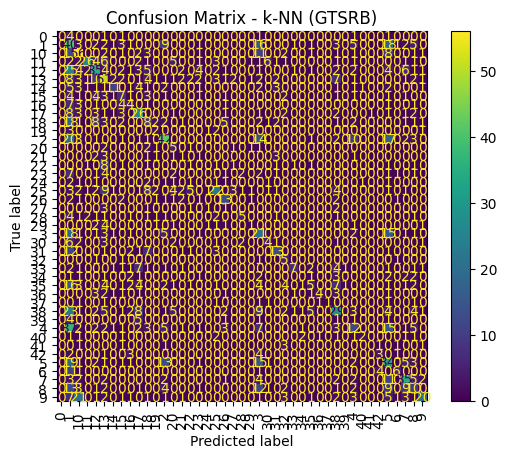

In [18]:
cm_knn = confusion_matrix(y_test, knn_preds)
disp_knn = ConfusionMatrixDisplay(cm_knn, display_labels=class_names)
disp_knn.plot(xticks_rotation=90)
plt.title("Confusion Matrix - k-NN (GTSRB)")
plt.show()


In [19]:
C_STAR_GTSRB = 0.1


In [20]:
svm = SVC(kernel="linear", C=C_STAR_GTSRB, decision_function_shape="ovr")
svm.fit(X_train_bovw, y_train)

svm_preds = svm.predict(X_test_bovw)
svm_acc = accuracy_score(y_test, svm_preds)

print("✅ SVM Accuracy (GTSRB):", svm_acc)


✅ SVM Accuracy (GTSRB): 0.46394351991931415


In [21]:
print("📊 Classification Report SVM:\n")
print(classification_report(y_test, svm_preds, target_names=class_names))


📊 Classification Report SVM:

              precision    recall  f1-score   support

           0       0.75      0.33      0.46         9
           1       0.68      0.52      0.59       114
          10       0.21      0.82      0.33       104
          11       0.86      0.73      0.79        66
          12       0.50      0.53      0.51       109
          13       0.53      0.61      0.57       114
          14       0.64      0.55      0.59        42
          15       0.43      0.48      0.46        33
          16       1.00      0.39      0.56        23
          17       0.64      0.44      0.52        57
          18       0.53      0.33      0.40        61
          19       0.28      0.56      0.37         9
           2       0.66      0.58      0.62       118
          20       0.67      0.43      0.52        14
          21       0.10      0.07      0.08        14
          22       0.53      0.42      0.47        19
          23       0.21      0.13      0.16        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


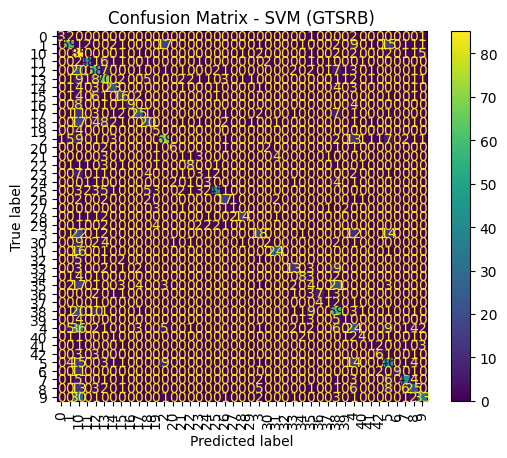

In [22]:
cm_svm = confusion_matrix(y_test, svm_preds)
disp_svm = ConfusionMatrixDisplay(cm_svm, display_labels=class_names)
disp_svm.plot(xticks_rotation=90)
plt.title("Confusion Matrix - SVM (GTSRB)")
plt.show()


In [23]:
comparison_gtsrb = pd.DataFrame({
    "Μοντέλο": ["k-NN", "SVM"],
    "Accuracy": [knn_acc, svm_acc]
})

comparison_gtsrb


,Μοντέλο,Accuracy
0,k-NN,0.285930
1,SVM,0.463944


In [24]:
comparison_gtsrb.to_csv("experiment_4_final_comparison_GTSRB.csv", index=False)
print("✅ Αποθήκευση ολοκληρώθηκε!")


✅ Αποθήκευση ολοκληρώθηκε!


Στο dataset GTSRB, το k-NN παρουσίασε χαμηλή απόδοση, με μέγιστη ακρίβεια 28.59% για k=1. Αντιθέτως, το γραμμικό SVM με C=0.1 πέτυχε ακρίβεια 46.39%, υπερέχοντας σημαντικά του k-NN κατά 17.8%. Το αποτέλεσμα αυτό επιβεβαιώνει την ανωτερότητα του SVM έναντι των μεθόδων βασισμένων σε τοπική απόσταση, ιδιαίτερα σε προβλήματα υψηλής πολυκατηγορικότητας και έντονης ομοιότητας μεταξύ κλάσεων, όπως το GTSRB